In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

root_path = os.getenv('HOME')+'/aiffel/camera_sticker/'

## 스티커 합성 클래스 구현

In [2]:
class FaceOnCat:
    image_path = ""
    debug = False
    detector_hog = dlib.get_frontal_face_detector()

    def __init__(self, image, debug=False):
        self.image_path = root_path + 'images/' + image
        self.debug = debug
        
        if not os.path.isfile(self.image_path):
            raise Exception("이미지 파일을 찾을 수 없습니다:", self.image_path)

    def standby(self):
        self.img_bgr = cv2.imread(self.image_path)
        self.img_show = self.img_bgr.copy()
        if self.debug:
            plt.imshow(self.img_bgr)
            print("[BGR Image]")
            plt.show()
        
        # plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
        self.img_rgb = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB)
        
        if self.debug:
            plt.imshow(self.img_rgb)
            print("[BGR to RGB Image]")
            plt.show()
    
    def face_box_detector(self):
        img_rgb = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB)
        self.dlib_rects = self.detector_hog(self.img_rgb, 1)   # (image, num of image pyramid)
        
        # 찾은 얼굴 영역 박스 리스트
        # 여러 얼굴이 있을 수 있습니다
        if self.debug:
            print("Detect list:", self.dlib_rects)

        for dlib_rect in self.dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(self.img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

        img_show_rgb =  cv2.cvtColor(self.img_show, cv2.COLOR_BGR2RGB)
        if self.debug:
            plt.imshow(img_show_rgb)
            plt.show()
    
    def face_point_detector(self):
        if not self.dlib_rects:
            raise Exception("인식된 얼굴이 없습니다")
            
        model_path = root_path + 'models/shape_predictor_68_face_landmarks.dat'
        landmark_predictor = dlib.shape_predictor(model_path)
        
        self.list_landmarks = []

        # face landmark
        for dlib_rect in self.dlib_rects:
            points = landmark_predictor(self.img_rgb, dlib_rect)
            # face landmark 좌표를 저장해둡니다
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            self.list_landmarks.append(list_points)

        if self.debug:
            print("list_landmarks:", len(self.list_landmarks[0]))
        
        for landmark in self.list_landmarks:
            for point in landmark:
                cv2.circle(self.img_show, point, 2, (0, 255, 255), -1)

        img_show_rgb = cv2.cvtColor(self.img_show, cv2.COLOR_BGR2RGB)
        if self.debug:
            plt.imshow(img_show_rgb)
            plt.show()

    def attach_sticker(self, sticker="king.png"):
        sticker_path = root_path + 'images/' + sticker
        if not os.path.isfile(sticker_path):
            raise Exception("스티커를 찾을 수 없습니다:", sticker_path)
            
        for dlib_rect, landmark in zip(self.dlib_rects, self.list_landmarks):

            x = landmark[30][0]
            y = landmark[30][1] - dlib_rect.height()//2
            w = h = dlib_rect.width()
            if self.debug:
                print (landmark[30])
                print ('(x,y) : (%d,%d)'%(x,y))
                print ('(w,h) : (%d,%d)'%(w,h))

        img_sticker = cv2.imread(sticker_path)
        img_sticker = cv2.resize(img_sticker, (w,h))

        if self.debug:
            print (img_sticker.shape)
            print("[Attach Sticker]")
            plt.imshow(img_sticker)
            plt.show()

        # 스티커별로 refined 범위를 정의해서
        # 여러개를 붙일 수 있도록 업그레이드 할 수 있을듯
        refined_x = x - w // 2
        refined_y = y

        if self.debug:
            print ('refined1 (x,y) : (%d,%d)'%(refined_x, refined_y))
        
        if refined_x < 0: 
           img_sticker = img_sticker[:, -refined_x:]
           refined_x = 0
        if refined_y < 0:
           img_sticker = img_sticker[-refined_y:, :]
           refined_y = 0

        if self.debug:
            print ('refined2 (x,y) : (%d,%d)'%(refined_x, refined_y))
        
        sticker_area = self.img_bgr[
            refined_y:refined_y + img_sticker.shape[0], 
            refined_x:refined_x + img_sticker.shape[1]
        ]

        self.img_bgr[
            refined_y:refined_y + img_sticker.shape[0], 
            refined_x:refined_x + img_sticker.shape[1]
        ] = np.where(
            img_sticker==255,
            sticker_area,
            cv2.addWeighted(img_sticker, 0.6, sticker_area, 0.4, 0)
        ).astype(np.uint8)
        plt.imshow(cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    
    def do_attach(self, sticker="king.png"):
        self.standby()
        self.face_box_detector()
        self.face_point_detector()
        self.attach_sticker(sticker)

### 1. 샘플이미지에 고양이 수염 올리기

[BGR Image]


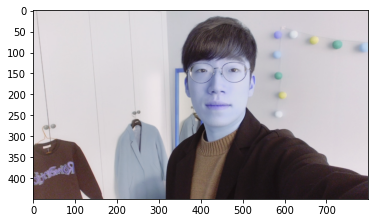

[BGR to RGB Image]


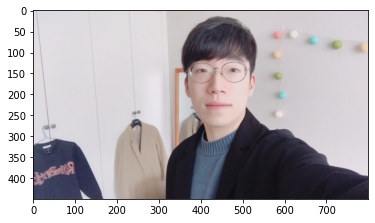

Detect list: rectangles[[(345, 98) (531, 284)]]


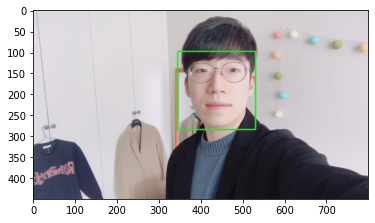

list_landmarks: 68


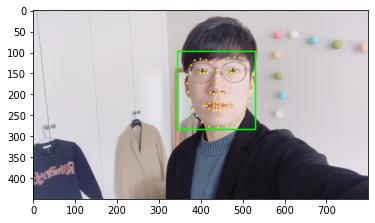

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)
(187, 187, 3)
[Attach Sticker]


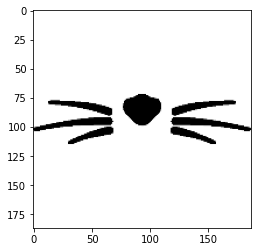

refined1 (x,y) : (344,89)
refined2 (x,y) : (344,89)


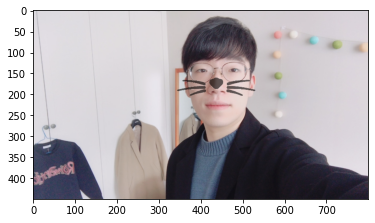

In [3]:
image1 = FaceOnCat("image.png", debug=True)
image1.do_attach("cat-whiskers.png")

### 2. 다양한 각도의 얼굴이 있을 때

[BGR Image]


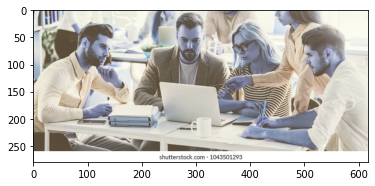

[BGR to RGB Image]


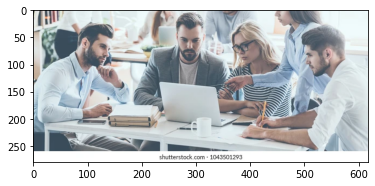

Detect list: rectangles[[(266, 46) (309, 89)]]


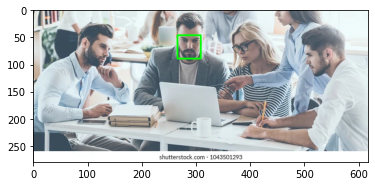

list_landmarks: 68


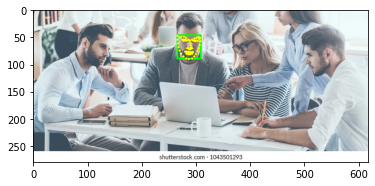

(290, 69)
(x,y) : (290,47)
(w,h) : (44,44)
(44, 44, 3)
[Attach Sticker]


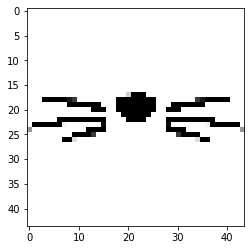

refined1 (x,y) : (268,47)
refined2 (x,y) : (268,47)


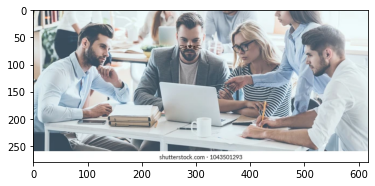

In [4]:
image2 = FaceOnCat("many-people.jpg", debug=True)
image2.do_attach("cat-whiskers.png")

> 다양한 얼굴각도가 있을 때, 정면을 응시하는 얼굴만 인식이 가능했다

### 3. 정면 각도를 5도씩 회전한다면 몇도까지 허용하는가?

[Rotate angle 15] -----------------


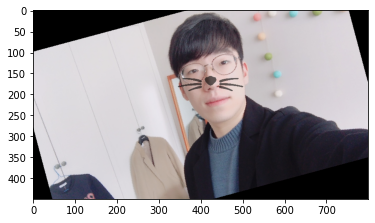

[Rotate angle 20] -----------------


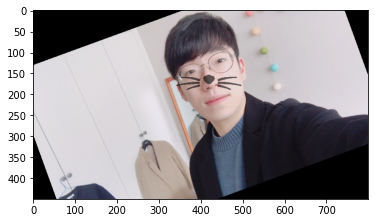

[Rotate angle 25] -----------------


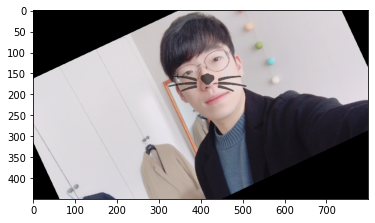

[Rotate angle 30] -----------------


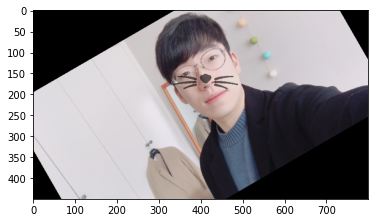

[Rotate angle 35] -----------------


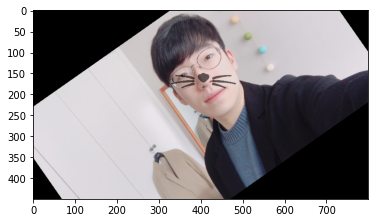

[Rotate angle 40] -----------------


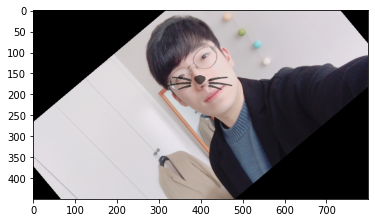

[Rotate angle 45] -----------------


Exception: 인식된 얼굴이 없습니다

In [5]:
from PIL import Image

#read the image
im = Image.open(root_path + "images/image.png")

#rotate image
for angle in range(15, 46, 5):
    out = im.rotate(angle)
    out.save(root_path + 'images/image-rotate.png')
    
    print(f"[Rotate angle {angle}] -----------------")
    image3 = FaceOnCat("image-rotate.png", debug=False)
    image3.do_attach("cat-whiskers.png")

> 사진을 15도부터 45도까지 5도씩 회전시키며 확인해보니
> 45도 부턴 얼굴 인식이 불가능했다

### 4. 누워있어서 얼굴이 가려진 상태

[BGR Image]


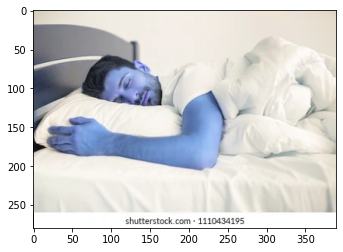

[BGR to RGB Image]


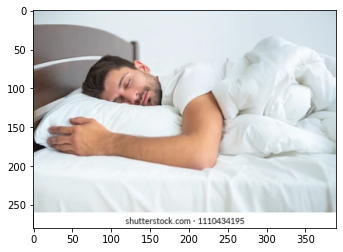

Detect list: rectangles[]


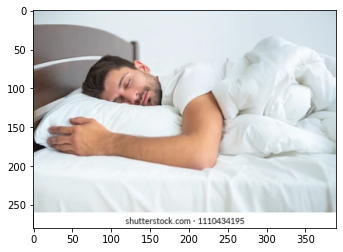

Exception: 인식된 얼굴이 없습니다

In [6]:
image4 = FaceOnCat("man-sleeping-on-bed.jpg", debug=True)
image4.do_attach("cat-whiskers.png")

> 얼굴이 90도로 뉘어있고 가려져있어 얼굴 인식이 불가능하다

## 결론

* 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    * 얼굴 각도에 따라서 스티커도 입체적으로 회전해야 한다
* 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    * 멀리서 촬영하거나 옆으로 누워서 촬영하는 경우, 모델이 얼굴 인식을 정확히 하지 못하는 문제가 있음
* 실행 속도가 중요할까요?
    * 실시간으로 촬영 화면을 보면서 마음에 드는 구도와 스티커를 골라 촬영하기 때문에 실행속도는 매우 중요할 것 같다
* 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
    * 스티커를 완벽한 위치에 위치시키지 못하더라도 의도된 근사치 부근에 올려주어야 촬영 당사자가 이용할 수 있을 것 같다